**Nota**: Leer antes el archivo "memoria_TFM.pdf" 

# TFM CÁLIDAD DEL USUARIO

## Este notebook consta de las siguientes partes:

- Importación de librerías
- Preparación del data frame
- Análisis y estudio del proceso de compra
- Visualización de las variables
- Correlación y eliminación de variables
- Normalización de los datos
- Reducción de dimensionalidad y visualización
- Machine learning
- Conclusión

### Importación de librerías

En la siguiente celda están todas las importaciones de librerías que se deben hacer para este notebook, no obstante, conforme se vayan necesitando se volverán a importar para tener claro para que se están usando.

In [1]:
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.figure_factory as ff
from __future__ import division
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Preparación del data frame

**Nota1**: La mayoría de los archivos que usaremos han sido previeamente modificados por motivos de privacidad, por lo que al importarlos usaremos *index_col=0* ya que ya tenían indice. Ninguna de estas modificaciones afecta al resultado del proyecto.

**Nota2**: Todos los archivos que importaremos son .csv y estaran en la misma carpeta de este notebook.

#### Primera consulta de analytics

Importamos la primera consulta que hemos realizado (usuarios_proceso_y_so.csv) en google analytics. Este archivo contiene a los usuarios que han accedido al proceso y el sistema operativo desde el que han accedido (Mac OS o Windows OS). También tenemos otra columna de usuarios pero la eliminaremos ya que no nos es útil.

In [2]:
# Librerías para la preparación del dataframe

import pandas as pd
import numpy as np

In [3]:
# Importamos usando pandas
usu_so = pd.read_csv('./usuarios_proceso_y_so.csv', index_col=0)
# Veamos que pinta tiene el archivo
print usu_so.head()
print ""
print 'Tenemos %i filas y %i columnas' %(usu_so.shape[0], usu_so.shape[1])

  identificador Sistema operativo  Usuarios
0       245701u        Windows OS         1
1         1120u        Windows OS         1
2       267373u            Mac OS         1
3       149066u        Windows OS         1
4        90480u        Windows OS         1

Tenemos 28960 filas y 3 columnas


In [4]:
# Modificamos el nombre de las columnas por motivos de uniformidad.
# El formato siempre sera: minúsculas, sin tildes y con barra baja como espacio.
usu_so.columns = ['identificador', 'so', 'usuarios']
# Eliminamos la columna usuarios ya que no nos aporta nada.
usu_so.drop('usuarios', 1, inplace = True)

Para empezar a preparar nuestro data frame debemos quedarnos con los identificadores únicos de usu_so. Obviamente un usuario ha podido acceder al proceso desde un solo sistema operativo o desde los dos, por tanto, tenemos que eliminar identificadores duplicados.

In [5]:
# Esto podemos hacerlo con pandas o con un bucle for con numpy.
# Bajo mi punto de vista la forma más fácil es con pandas.

# Con pandas
# Copiamos usu_so en un nuevo dataframe.
df = usu_so.copy()
# Ordenamos por la columna identificador y eliminamos los duplicados
df.sort_values('identificador', inplace=True)
df.drop_duplicates('identificador', inplace=True)
# Eliminamos la columna del sistema operativo para quedarnos solo con el identificador
df.drop('so', 1, inplace=True)

print 'Había %i usuarios duplicados' %(len(usu_so)-len(df))
print 'Han entrado %i usuarios en el periodo seleccionado en la consulta' %(len(df))

Había 125 usuarios duplicados
Han entrado 28835 usuarios en el periodo seleccionado en la consulta


In [6]:
# Faltaría hacer la celda anterior con un bucle for en numpy

Ya tenemos la primera columna de nuestro data frame. Iremos añadiendo nuevas variables a este.

Como primera variable y aprovechando que tenemos importado el archivo de los sistemas operativos, crearemos una nueva variable que pueda tener 3 valores diferentes:
- 0 si el sistema operativo solo es Mac OS.
- 1 si el sistema operativo solo es Windows OS.
- 2 si el sistema operativo han sido ambos.

In [7]:
# Primero ordenamos el data frame por identificador de usuario
usu_so.sort_values('identificador', inplace=True)

sist_ope = [] # Creamos una lista vacía donde iremos añadiendo el resultado 0,1 o 2.
usuarios = [] # Creamos otra lista vacía donde iremos añadiendo los usuarios que ya tenemos.

# La idea es hacer un bucle que recorra una lista de tuplas e ir añadiendo los identificadores
# a la lista creada 'usuarios' y conforme añadamos usuarios, si el identificador ya está en la lista
# sabremos que ese usuario ha accedido desde ambos sistemas operativos y por tanto sera un 2 en 'sist_ope'
for usuario_so in usu_so.values.tolist():
    
    if usuario_so[0] in usuarios: # Con usuario_so[0] accedemos a el primer valor de la tupla
        
        # Si el usuario ya estaba cambiamos el ultimo valor añadido por un 2
        # El último valor añadido era 0 o 1 de ese mismo usuario.
        sist_ope[len(sist_ope)-1] = 2
        
    else:
        usuarios.append(usuario_so[0]) # Si no estaba en la lista de usuarios, lo añadimos
        if usuario_so[1] == 'Mac OS':  # Si es Mac OS añadimos un 0 a sist_ope
            sist_ope.append(0)
        else:
            sist_ope.append(1)         # Si no, será Windows OS y añadimos un 1

In [8]:
# Pendiente hacer una función

In [9]:
# Si hemos hecho bien el bucle anterior el número de valores 2 en sist_ope
# debería ser igual a 125 (usuarios duplicados)
print len ([l for l in sist_ope if l==2])

# len(sist_ope)  y len(usuarios) deberían ser igual que len(df)
print len(sist_ope)
print len(usuarios)
print len(df)

125
28835
28835
28835


In [10]:
# Vamos a convertir 'sist_ope' y 'usuarios' en un dataframe para hacer un merge por el identificador
temp = pd.DataFrame({'identificador':usuarios, 'ssoo':sist_ope})

# Unimos los dataframes y ya tenemos nuestra primera variable.
df = pd.merge(df, temp, on='identificador', how='left')

df.head()

,identificador,ssoo
0,100016u,0
1,100018u,0
2,100026u,1
3,100027u,1
4,100036u,1


#### Segunda consulta de analytics


Importamos la segunda consulta que hemos hecho en google analytics. En este archivo encontramos lás páginas del proceso que ha visitado cada usuario, el tiempo medio que ha estado en cada una de ellas, el número de veces que ha visto cada página y el número de visualizaciones únicas de cada página.

In [11]:
datos_proceso = pd.read_csv('./datos_proceso.csv', index_col=0)
datos_proceso.head()

,identificador,Página,Promedio de tiempo en la página,Número de visitas a páginas,Número de visitas a páginas únicas
0,245701u,page1,10.000000,1,1
1,1120u,page1,37.000000,1,1
2,267373u,page1,3.000000,3,3
3,149066u,page1,8.800000,10,6
4,149066u,page2,7.333333,4,3


Vamos a tratar este archivo para añadir varias variables a nuestro dataframe. Empezaremos cálculando la profundidad del usuario, es decir, lo lejos que ha llegado el usuario en el proceso. El valor irá de 1 a 4 en función de si se quedo en la página 1,2,3 o 4.

In [12]:
# Puesto que un usuario aparece una vez para cada página que ha visto, para calcular la profundidad
# solo necesitamos la columna 'identificador' y contar cuantas veces aparece cada usuario
# Básicamente vamos a hacer el "The word-count problem" con nuestro identificadores.

def countUsers(lista): # Definimos la función que cálcula la profundidad.
    """
    method para contar veces que aparece un usuario
    inputs:
        *lista: lista de usuarios
    output: diccionario de {'ID usuario':profundidad en el proceso}
    """
    hist = {} # Creamos un diccionario vacío
    for user in lista:
        if user in hist:
            hist[user] += 1
        else:
            hist[user] = 1
    return hist

dict_user = countUsers(datos_proceso['identificador']) # aplicamos la función a nuestra lista de usuarios
profundidad = pd.DataFrame(dict_user.items(), columns=['identificador','profundidad']) # Diccionario a dataframe

# Añadimos la nueva variable anuestro dataframe
df = pd.merge(df,profundidad, on ='identificador', how='left')

In [13]:
df.head()

,identificador,ssoo,profundidad
0,100016u,0,1
1,100018u,0,4
2,100026u,1,1
3,100027u,1,1
4,100036u,1,1


El siguiente paso es añadir 12 variables usando el archivo que hemos importado previamente (datos_proceso.csv)
Estas variables representaran el tiempo, número de visitas y número de visitas únicas que cada usuario está en cada página.

Para conseguir esto, tendremos que hacer un merge para cada página del proceso.

In [14]:
# añadimos datos pagina 1
# A la vez que añadimos filtramos por page 1, eliminamos la columna página y
# cambiamos el nombre a las columnas
df = (pd.merge(df, datos_proceso[datos_proceso['Página']=='page1'].
               drop('Página',1).
                   rename(columns = {'Promedio de tiempo en la página':'avg_tiempo_pag1',
                                     'Número de visitas a páginas':'vistas_pag1',
                                     'Número de visitas a páginas únicas':'vistas_unicas_pag1'}),
               how='left', on='identificador'
              ))


# añadimos datos pagina 2
# A la vez que añadimos filtramos por page 2, eliminamos la columna página y
# cambiamos el nombre a las columnas
df = (pd.merge(df, datos_proceso[datos_proceso['Página']=='page2'].
               drop('Página',1).
                   rename(columns = {'Promedio de tiempo en la página':'avg_tiempo_pag2',
                                     'Número de visitas a páginas':'vistas_pag2',
                                     'Número de visitas a páginas únicas':'vistas_unicas_pag2'}),
               how='left', on='identificador'
              ))


# añadimos datos pagina 3
# A la vez que añadimos filtramos por page 3, eliminamos la columna página y
# cambiamos el nombre a las columnas
df = (pd.merge(df, datos_proceso[datos_proceso['Página']=='page3'].
               drop('Página',1).
                   rename(columns = {'Promedio de tiempo en la página':'avg_tiempo_pag3',
                                     'Número de visitas a páginas':'vistas_pag3',
                                     'Número de visitas a páginas únicas':'vistas_unicas_pag3'}),
               how='left', on='identificador'
              ))


# añadimos datos pagina 4
# A la vez que añadimos filtramos por page 4, eliminamos la columna página y
# cambiamos el nombre a las columnas
df = (pd.merge(df, datos_proceso[datos_proceso['Página']=='page4'].
               drop('Página',1).
                   rename(columns = {'Promedio de tiempo en la página':'avg_tiempo_pag4',
                                     'Número de visitas a páginas':'vistas_pag4',
                                     'Número de visitas a páginas únicas':'vistas_unicas_pag4'}),
               how='left', on='identificador'
              ))


In [15]:
df.head()

,identificador,ssoo,profundidad,avg_tiempo_pag1,vistas_pag1,vistas_unicas_pag1,avg_tiempo_pag2,vistas_pag2,vistas_unicas_pag2,avg_tiempo_pag3,vistas_pag3,vistas_unicas_pag3,avg_tiempo_pag4,vistas_pag4,vistas_unicas_pag4
0,100016u,0,1,15.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100018u,0,4,24.000000,1,1,5.0,1.0,1.0,53.0,1.0,1.0,4.0,1.0,1.0
2,100026u,1,1,33.666667,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100027u,1,1,19.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100036u,1,1,5.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Antes de seguir, es recomendable comprobar que no tengamos NaNs en las
# variables de la página 1.
df[df.columns[3:6]].isnull().values.any()

False

No tenemos porque cuando hicimos la primera consulta, solo nos quedamos con usuarios que habían llegado a esta primera página. Pero si hubieramos hecho una consulta en analytics aproximada (del que la página empiece por...), es muy probable que para determinados usuarios no tengamos rastro de su paso por la primera página pero si en la segunda. Puede haber varias causas de esto:
- No es obligatorio pasar por la primera página
- Error en google analytics
- Alguna campaña o banner que permita acceder a otra página del proceso directamente.

En el proceso que hemos elegido es obligatorio pasar por la primera página y si hubieramos encontrado NaNs en estas variables deberiamos eliminar a estos usuarios ya que serían errores de analytics.
El código par eliminarlos sería el siguiente:

df = df[df.colums[3:6].notnull()]



#### Tercera consulta de analytics

Importamos nuestra tercera consulta. Esta consulta contiene datos generales de navegación de todos los usuarios de nuestro sitio web.

**Nota**: Por razones de privacidad la únion de los datos se ha realizado en un notebook aparte. En cualquier caso, el proceso de unión de tablas es igual que si tuvieramos todos los usuarios del sitio web.

Simplemente añadiremos estos datos a nuestro data frame de usuarios que accedieron al proceso

In [17]:
datos_generales = pd.read_csv('./datos_generales_usuarios.csv', index_col=0)

# Añadimos las variables a nuestros datos

df = (pd.merge(df, datos_generales.rename(columns={'Sesiones':'sesiones',
                                                   'Número de visitas a páginas':'vistas',
                                                   'Número de visitas a páginas únicas':'vistas_unicas',
                                                   'Duración media de la sesión':'duracion_media_sesion'})
               , how='left', on='identificador'))
df.head()

,identificador,ssoo,profundidad,avg_tiempo_pag1,vistas_pag1,vistas_unicas_pag1,avg_tiempo_pag2,vistas_pag2,vistas_unicas_pag2,avg_tiempo_pag3,vistas_pag3,vistas_unicas_pag3,avg_tiempo_pag4,vistas_pag4,vistas_unicas_pag4,sesiones,vistas,vistas_unicas,duracion_media_sesion
0,100016u,0,1,15.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,880,306,197.580000
1,100018u,0,4,24.000000,1,1,5.0,1.0,1.0,53.0,1.0,1.0,4.0,1.0,1.0,20,146,60,166.900000
2,100026u,1,1,33.666667,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,502,213,199.625000
3,100027u,1,1,19.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,609,264,111.293478
4,100036u,1,1,5.000000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,100,35,197.571429


#### Cuarta y última consulta

Con esta consulta hemos conseguido saber que usuarios han visto un error en el proceso, que tipo de error han visto y cuantas veces lo han visto.

**Nota**: Los mensajes de error han sido modificados por motivos de privacidad. En su lugar hay dos tipos de error, user_error si el error se produce por un fallo del usuario o process_error si se ha producido algún error por razones ajenas al usuario. Hay que tener en cuenta que antes de la modificación había 11 tipos diferentes de error y ahora solo tenemos 2 por lo que es probable que haya usuarios repetidos con el mismo tipo de error en los cuales hay que sumar el total de vistas de los errores de ese tipo.

In [18]:
errores = pd.read_csv('./errores.csv', index_col=0)
errores.head()

,identificador,Página,error,Número de visitas a páginas
0,284744u,page3,user_error,20
1,222252u,page3,user_error,18
2,171630u,page3,user_error,12
3,11180u,page3,user_error,11
4,31015u,page3,user_error,11


In [19]:
# Comprobamos en que páginas se producen los errores
errores.groupby(['Página','error']).count()

identificador  Número de visitas a páginas
Página error                                                    
page3  process_error             22                           22
       user_error               824                          824

Como vemos, todos los errores se producen en la página 3 de nuestro proceso. Esto se debe a las caracteristicas del proceso que hemos elegido.

Añadiremos dos nuevas variables. La primera indicará el número de errores de usuario que ha visto un usuario y la segunda el número de errores de proceso que ha visto el usuario.

In [20]:
# No necesitamos la columna página puesto que todos los errores se producen en page3
errores.drop('Página',1 , inplace=True)

# Neceitamos agrupar cada tipo de error por usuario y sumar el total de cada error
error_agrupados = errores.groupby(['identificador','error']).sum()

# Pasamos los indices a columnas para hacer el merge como siempre
error_agrupados.reset_index(level=['identificador','error'], inplace=True)

In [21]:
# Añadimos los errores de usuario
# Eliminamos la columna página puesto que todos los errores se producen en la página 3
# Eliminamos la columna del error ya que estamos añadidendo solo los user_error
df = (df.merge(error_agrupados[error_agrupados['error']=='user_error'].
               drop('error',1).
                   rename(columns = {'Número de visitas a páginas':'vistas_user_error'}),
               how='left', on='identificador'
              ))



# Añadimos los errores del proceso
# Eliminamos la columna página puesto que todos los errores se producen en la página 3
# Eliminamos la columna del error ya que estamos añadidendo solo los process_error
df = (df.merge(error_agrupados[error_agrupados['error']=='process_error'].
               drop('error',1).
                   rename(columns = {'Número de visitas a páginas':'vistas_process_error'}),
               how='left', on='identificador'
              ))

#df.head()

Ya hemos usado todas las consultas que hemos realizado en analytics. Se podrían realizar otras consultas para conseguir otro tipo de variables, como por ejemplo, el navegador, el dispositivo, la ubicación, etc.

#### Cálculo de nuevas variables
Antes de terminar con nuestro dataframe, añadiremos algunas variables nuevas haciendo sencillos cálculos. Para poder operar antes debemos cambiar los NaNs por ceros.

**Nota**: Estos NaNs significan que el usuario no ha llegado a esas páginas del proceso.

In [22]:
# Sustituimos los NaNs por 0
df = df.fillna(0)

# Comprobamos que ya no tenemos NaNs
df.isnull().values.any()

False

In [23]:
# Calculamos nuevas variables


# Tiempo medio que el usuario esta en el proceso
# Sumaremos el tiempo de la pagina 1,2 y 3
# El tiempo en la pag 4 no nos interesa puesto que es una página en la 
# que se confirma que la compra ha sido realizada con éxito.
df['avg_tiempo_proceso'] = df['avg_tiempo_pag1'] + df['avg_tiempo_pag2'] + df['avg_tiempo_pag3']

# Tiempo medio que el usuario no está en el proceso
# Restamos la duración media de la sesión al tiempo medio que el usuario está en el proceso
# Esta vez si tenemos en cuenta el tiempo medio de la página 4
df['avg_tiempo_no_proceso'] = df['duracion_media_sesion'] - (df['avg_tiempo_proceso']+df['avg_tiempo_pag4'])

df.head()

,identificador,ssoo,profundidad,avg_tiempo_pag1,vistas_pag1,vistas_unicas_pag1,avg_tiempo_pag2,vistas_pag2,vistas_unicas_pag2,avg_tiempo_pag3,...,vistas_pag4,vistas_unicas_pag4,sesiones,vistas,vistas_unicas,duracion_media_sesion,vistas_user_error,vistas_process_error,avg_tiempo_proceso,avg_tiempo_no_proceso
0,100016u,0,1,15.000000,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,50,880,306,197.580000,0.0,0.0,15.000000,182.580000
1,100018u,0,4,24.000000,1,1,5.0,1.0,1.0,53.0,...,1.0,1.0,20,146,60,166.900000,0.0,0.0,82.000000,80.900000
2,100026u,1,1,33.666667,3,3,0.0,0.0,0.0,0.0,...,0.0,0.0,56,502,213,199.625000,0.0,0.0,33.666667,165.958333
3,100027u,1,1,19.000000,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,92,609,264,111.293478,0.0,0.0,19.000000,92.293478
4,100036u,1,1,5.000000,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,7,100,35,197.571429,0.0,0.0,5.000000,192.571429


In [24]:
# Para que se muestren todas las columnas
pd.set_option('display.max_columns',100)
df.head()

,identificador,ssoo,profundidad,avg_tiempo_pag1,vistas_pag1,vistas_unicas_pag1,avg_tiempo_pag2,vistas_pag2,vistas_unicas_pag2,avg_tiempo_pag3,vistas_pag3,vistas_unicas_pag3,avg_tiempo_pag4,vistas_pag4,vistas_unicas_pag4,sesiones,vistas,vistas_unicas,duracion_media_sesion,vistas_user_error,vistas_process_error,avg_tiempo_proceso,avg_tiempo_no_proceso
0,100016u,0,1,15.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,880,306,197.580000,0.0,0.0,15.000000,182.580000
1,100018u,0,4,24.000000,1,1,5.0,1.0,1.0,53.0,1.0,1.0,4.0,1.0,1.0,20,146,60,166.900000,0.0,0.0,82.000000,80.900000
2,100026u,1,1,33.666667,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,502,213,199.625000,0.0,0.0,33.666667,165.958333
3,100027u,1,1,19.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92,609,264,111.293478,0.0,0.0,19.000000,92.293478
4,100036u,1,1,5.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,100,35,197.571429,0.0,0.0,5.000000,192.571429


Antes de seguir eliminaré algunas variables que ya no necesitaremos.

In [25]:
for name in dir():
    if name.startswith('_'):
        pass
    elif name in ['df','np','pd']:
        pass
    else:
        del globals()[name]

### Análisis y estudio del proceso de compra

Antes de empezar a pensar que algoritmos de machine learning usaremos para obtener la probabilidad de que un usuario haya adquirido un producto o no, es necesario estudiar el proceso de compra en el que nos encontramos.

Este proceso concretamente tiene cuatro pasos:
1. Selección del producto y configuración.
2. Resumen del producto y configuración elegidos.
3. Página de pasarela de pago.
4. Página de confirmación, en la que se coinfirma que la compra ha sido realizada con éxito.

Veamos como es nuestro funnel de conversión con **plotly**. https://plot.ly/python/funnel-charts/
Usaré el ejemplo de esta página, haciendo ligeras modificaciones.

In [26]:
# Librerías para el análisis y visualización del funnel
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.figure_factory as ff
from __future__ import division
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)

In [27]:
# chart stages data
values = [len(df[df['profundidad']>=pag]) for pag in range(1,5)]
phases = ['Accesos' , 'page2', 'Page3', 'Page4']

# color of each funnel section
colors = ['rgb(182,231,235)','rgb(32,155,160)', 'rgb(28,119,139)', 'rgb(253,93,124)']

n_phase = len(phases)
plot_width = 400

# height of a section and difference between sections 
section_h = 100
section_d = 10

# multiplication factor to calculate the width of other sections
unit_width = plot_width / max(values)

# width of each funnel section relative to the plot width
phase_w = [int(value * unit_width) for value in values]

# plot height based on the number of sections and the gap in between them
height = section_h * n_phase + section_d * (n_phase - 1)

# list containing all the plot shapes
shapes = []

# list containing the Y-axis location for each section's name and value text
label_y = []

for i in range(n_phase):
        if (i == n_phase-1):
                points = [phase_w[i] / 2, height, phase_w[i] / 2, height - section_h]
        else:
                points = [phase_w[i] / 2, height, phase_w[i+1] / 2, height - section_h]

        path = 'M {0} {1} L {2} {3} L -{2} {3} L -{0} {1} Z'.format(*points)

        shape = {
                'type': 'path',
                'path': path,
                'fillcolor': colors[i],
                'line': {
                    'width': 1,
                    'color': colors[i]
                }
        }
        shapes.append(shape)
        
        # Y-axis location for this section's details (text)
        label_y.append(height - (section_h / 2))

        height = height - (section_h + section_d)
        
# For phase names
label_trace = go.Scatter(
    x=[-350]*n_phase,
    y=label_y,
    mode='text',
    text=phases,
    textfont=dict(
        color='rgb(200,200,200)',
        size=15
    )
)
 
# For phase values
value_trace = go.Scatter(
    x=[350]*n_phase,
    y=label_y,
    mode='text',
    text=values,
    textfont=dict(
        color='rgb(200,200,200)',
        size=15
    )
)

data = [label_trace, value_trace]
 
layout = go.Layout(
    title="<b>Funnel Chart</b>",
    titlefont=dict(
        size=20,
        color='rgb(203,203,203)'
    ),
    shapes=shapes,
    height=560,
    width=800,
    showlegend=False,
    paper_bgcolor='rgba(44,58,71,1)',
    plot_bgcolor='rgba(44,58,71,1)',
    xaxis=dict(
        showticklabels=False,
        zeroline=False,
    ),
    yaxis=dict(
        showticklabels=False,
        zeroline=False
    )
)
 
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Algunos datos significativos
print 'La conversión del proceso es de un {0:.1f}% .'.format(values[3]/values[0]*100)
print 'El {0:.1f}% de los usuarios no pasan de la primera página.'.format(100-(values[1]/values[0]*100))
print ''
print 'avg_tiempo_pag1 de los usuarios con profundidad 1 son %i segundos' %(df[df['profundidad']==1]['avg_tiempo_pag1'].mean())
print 'Con una desviación de %i segundos'%(df[df['profundidad']==1]['avg_tiempo_pag1'].std())
print ''
print 'avg_tiempo_pag1 de los usuarios con profundidad mayor o igual a 2 son %i segundos' %(df[df['profundidad']>1]['avg_tiempo_pag1'].mean())
print 'Con una desviación de %i segundos'%(df[df['profundidad']>1]['avg_tiempo_pag1'].std())
print ''
print 'avg_tiempo_pag1 de los usuarios que contratan son %i segundos' %(df[df['profundidad']==4]['avg_tiempo_pag1'].mean())
print 'Con una desviación de %i segundos'%(df[df['profundidad']==4]['avg_tiempo_pag1'].std())

La conversión del proceso es de un 42.8% .
El 49.3% de los usuarios no pasan de la primera página.

avg_tiempo_pag1 de los usuarios con profundidad 1 son 14 segundos
Con una desviación de 48 segundos

avg_tiempo_pag1 de los usuarios con profundidad mayor o igual a 2 son 17 segundos
Con una desviación de 28 segundos

avg_tiempo_pag1 de los usuarios que contratan son 17 segundos
Con una desviación de 26 segundos


Con este pequeño estudio, ya podemos intuir que la probabilidad de que un usuario adquiera el producto una vez ha pasado de la primera página es muy alta. No obstante, el objetivo del proyecto no cambia pese a esta evidencia puesto que, lo que queremos es aprender como obtener esta probabilidad para poder aplicarlo a cualquier otro proceso. El proceso que estamos analizando nos sirve como conejillo de indias.

Evidentemente, cada proceso será un mundo y habrá que detenerse a estudiar cada caso. Este trabajo fin de master servirá para asentar las bases de como se deben plantear este tipo de proyectos para conseguir el mejor resultado posible.

### Visualización de las variables

Vamos a ver rápidamente que pinta tienen todas nuestras variables con seaborn y matplotlib.

In [28]:
# Librerías necesarias

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

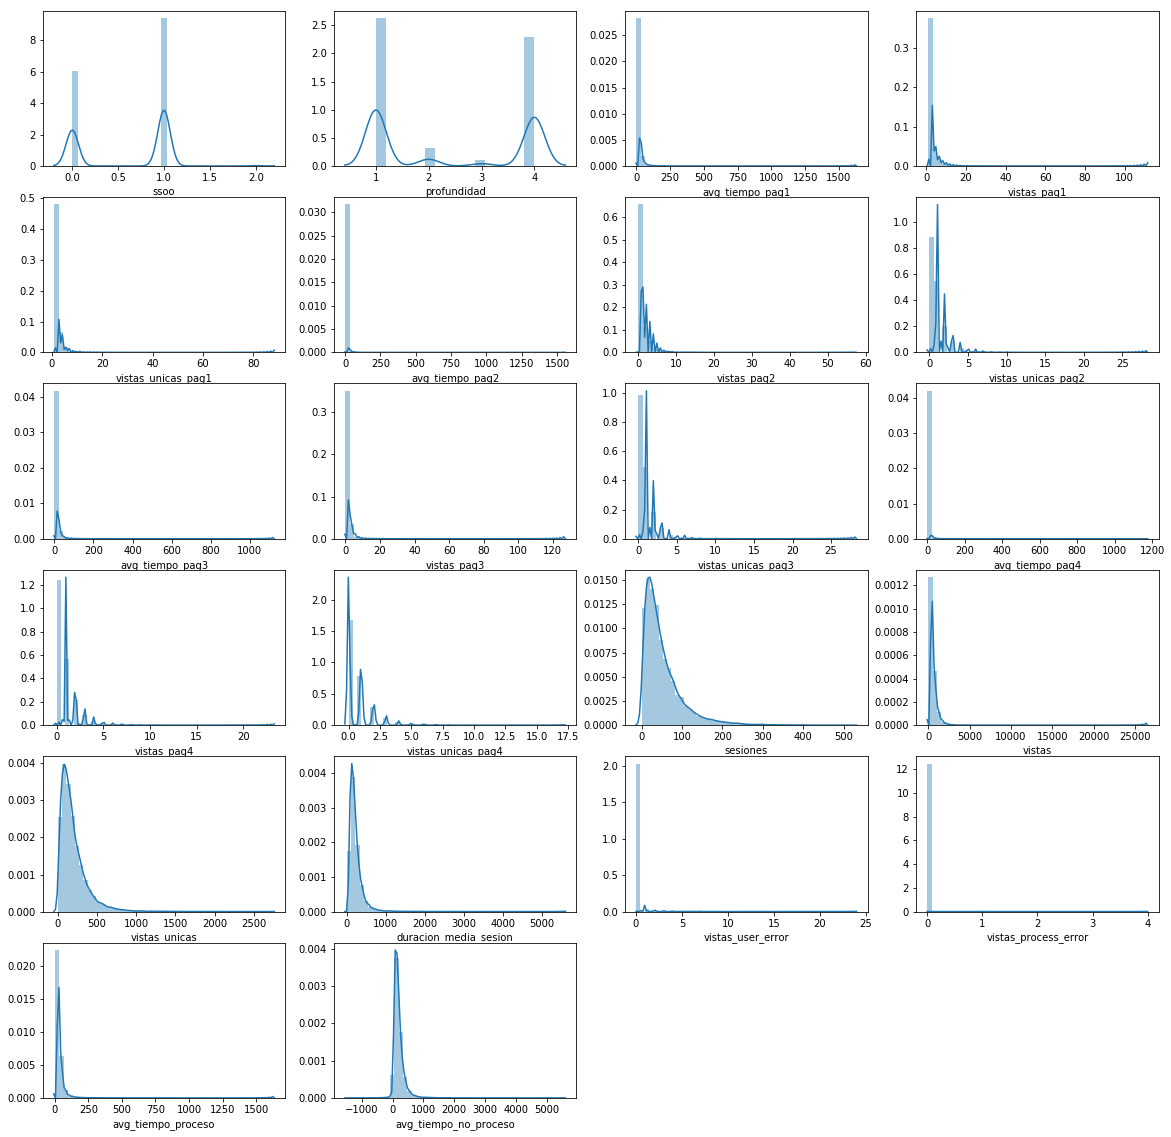

In [29]:
plt.figure(figsize=(20,20))
for index,col in enumerate(df.columns[1:]):
    plt.subplot(6,4,index+1)
    sns.distplot(df[col])

### Correlación y eliminación de variables

La idea para conseguir la probabilidad de que un usuario adquiera un producto es entrenar a un algoritmo de machine learning con datos de usuarios que han comprado y otros que no han comprado. Una vez conseguido esto ya tendremos la probabilidad que el algoritmo le haya dado a cada usuario de ser un 1 o ser un 0 (compró o no compró).

Si al algoritmo le pasamos demasiadas pistas, se percatará que hay variables que influyen muchísimo por estar muy correlacionadas con nuestras etiquetas. De modo, que haremos una matriz de correlación para saber que variables son aquellas que estan muy correlacionadas y las eliminaremos.

Para hacer la matriz de correlación usaremos seaborn. También usaremos plotly para conseguir una matriz interactiva.

In [30]:
# Librerías a importar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot") # Para conseguir la apariencia de ggplot

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [31]:
# Antes de nada tenemos que conseguir nuestras etiquetas
# Fácil, los usuarios con profundidad 4 tendran etiqueta 1, el resto 0
df['Y'] = df['profundidad']
df['Y'] = (df['Y'].replace(to_replace=[4,3,2,1],
           value=[1,0,0,0]))

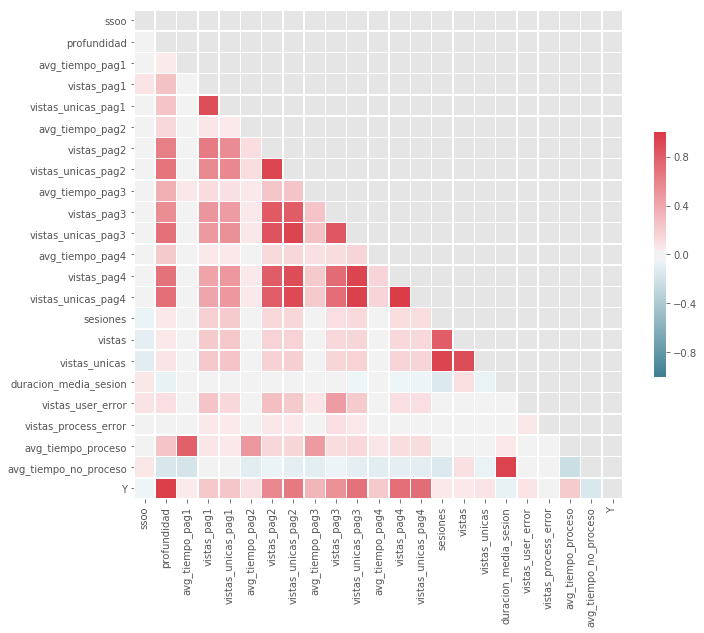

In [32]:
# Matriz con seaborn https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = (df[df.columns[1:]]).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
# Con pyplot https://plot.ly/python/heatmaps/
corr = (df[df.columns[1:]]).corr()
corr = corr.values.tolist()

axis = df.columns[1:]
axis = axis.tolist()

trace = (go.Heatmap(z=corr, x=axis, y=axis, colorscale=[[0, "rgb(0,0,255)"], [0.1, "rgb(51,153,255)"],
                                                        [0.2, "rgb(102,204,255)"], [0.3, "rgb(153,204,255)"],
                                                        [0.4, "rgb(204,204,255)"], [0.5, "rgb(255,255,255)"],
                                                        [0.6, "rgb(255,204,255)"], [0.7, "rgb(255,153,255)"],
                                                        [0.8, "rgb(255,102,204)"], [0.9, "rgb(255,102,102)"],
                                                        [1, "rgb(255,0,0)"]], zmax=1, zmin=-1))

data=[trace]

py.iplot(data, filename='basic-heatmap')

In [34]:
# Correlación con nuestra etiqueta
corr_Y = (df[df.columns[1:]]).corr()['Y']
corr_Y = corr_Y.sort_values(ascending=False)
axes = corr_Y.axes[0].get_values().tolist()
data = [go.Bar( x=axes, y=corr_Y)]

py.iplot(data, filename='basic-bar')

Como era de esperar, tenemos variables muy correlacionadas con nuestra etiqueta. Vamos a intentar entender por qué lo están y si debemos obviarlas a la hora de aplicar el algoritmo.

- **profundidad**: Como era de esperar esta muy correlacionada y obviamente tenemos que excluirla.
- **vairables pag4**: No están todo lo correlacionadas que cabría esperar. Pero esto se debe a que para este proceso en particular, es muy probable que un usuario realice la compra varias veces en un periodo corto de tiempo. En lo que a negocio se refiere, un usuario que ha comprado una vez ya es un usuario de calidad por lo que estas variables on prescindibles
- **vistas_unicas_pag3 y vistas_unicas_pag2**: Cuando vimos el funnel nos percatamos de que en este proceso una vez se ha pasado de la página 1 es muy alta la probabilidad de que se compre el producto, por tanto, es lógico pensar que estan correlacionadas. No obstante, esto es una característica de este proceso en concreto y bajo mi punto de vista esta información sigue siendo útil, ya que por ejemplo, un usuario que llegue a la página 3 y no convierta es un claro objetivo para una campaña de remarketing. No eliminaremos estas variables.

In [35]:
# Eliminamos las variables
df.drop(['profundidad','vistas_unicas_pag4','vistas_pag4','avg_tiempo_pag4'],1 , inplace=True)

In [36]:
df.head()

,identificador,ssoo,avg_tiempo_pag1,vistas_pag1,vistas_unicas_pag1,avg_tiempo_pag2,vistas_pag2,vistas_unicas_pag2,avg_tiempo_pag3,vistas_pag3,vistas_unicas_pag3,sesiones,vistas,vistas_unicas,duracion_media_sesion,vistas_user_error,vistas_process_error,avg_tiempo_proceso,avg_tiempo_no_proceso,Y
0,100016u,0,15.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,50,880,306,197.580000,0.0,0.0,15.000000,182.580000,0
1,100018u,0,24.000000,1,1,5.0,1.0,1.0,53.0,1.0,1.0,20,146,60,166.900000,0.0,0.0,82.000000,80.900000,1
2,100026u,1,33.666667,3,3,0.0,0.0,0.0,0.0,0.0,0.0,56,502,213,199.625000,0.0,0.0,33.666667,165.958333,0
3,100027u,1,19.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,92,609,264,111.293478,0.0,0.0,19.000000,92.293478,0
4,100036u,1,5.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,7,100,35,197.571429,0.0,0.0,5.000000,192.571429,0


### Normalización de los datos

Antes de hacer reducción de dimensionalidad para visualizar nuestro dataframe, es recomendable normalizar los datos para que las variables con valores más extremos no tengan más peso que el resto.

Usaremos el paquete preproccesing de la librería sklearn.

In [37]:
# Librerías a importar
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [38]:
df_norm = preprocessing.normalize((df[df.columns[1:19]]).values)
df_norm

array([[ 0.        ,  0.01544373,  0.00102958, ...,  0.        ,
         0.01544373,  0.18798109],
       [ 0.        ,  0.09080465,  0.00378353, ...,  0.        ,
         0.31024921,  0.30608733],
       [ 0.00164357,  0.05533366,  0.00493072, ...,  0.        ,
         0.05533366,  0.27276483],
       ..., 
       [ 0.        ,  0.03246102,  0.0032461 , ...,  0.        ,
         0.10062915,  0.32716067],
       [ 0.00375473,  0.02753466,  0.01126418, ...,  0.        ,
         0.10638392,  0.42531801],
       [ 0.00404953,  0.12553549,  0.00809906, ...,  0.        ,
         0.21057565, -0.03333076]])

In [39]:
df_norm = pd.DataFrame(data=df_norm, columns= [df.columns[1:19]])

df_norm['Y'] = df['Y']


### Reducción de dimensionalidad y visualización

Vamos a usar reducción de dimensionalidad para poder visualizar nuestros datos en dos y tres dimensiones con plotly.
En las pruebas realizadas (situadas en la carpeta dataTesting) hemos comprobado que el mejor algoritmo que podemos aplicar es PCA, por su rapidez de ejecución y por la representación que obtenemos al aplicarlo. 

En las pruebas se usaron ISOMAP, SVM y TSNE obteniendo resultados similares o peores y con un mayor tiempo de procesamiento.

In [40]:
# Importar
from sklearn.decomposition import pca
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [41]:
# Gráfico en 3 dimensiones

model = pca.PCA(n_components=3)

# Hacemos un sample porque si ploteamos tantos puntos se hace complicado movel el gráfico en 2 dimensiones,
df_norm_sample = df_norm.sample(3000)

# Seleccionamos solo nuestras features del sample
features_sample = df_norm_sample[df_norm_sample.columns[0:18]]

# Seleccionamos nuestra etiqueta para el color del gráfico
y_sample = df_norm_sample['Y']

# Reducimos dimensionalidad
features_pca=model.fit_transform(features_sample)

In [42]:
# Convertimos a listas para facilitar el trabajo
features_pca = features_pca.tolist()
y_sample = y_sample.tolist()

# Recorremos cada fila de features_pca y añadimos su etiqueta
for i in range(0,3000):
    features_pca[i].append(y_sample[i])

# Lista con solo los valores y = 0
features_0 = [k for k in features_pca if k[3]==0]
features_0 = np.asarray(features_0, dtype=np.float32) # array para que sea más fácil pasarlo a pyplot

# Lista con solo los valores y = 1
features_1 = [k for k in features_pca if k[3]==1]
features_1 = np.asarray(features_1, dtype=np.float32)

In [43]:
# Vamos a pasar los y=0 por un lado y los y=1 para poder diferenciarlos con un marcador

trace0= (go.Scatter3d(
    x= features_0[:,0],
    y= features_0[:,1],
    z= features_0[:,2],
    mode='markers',
    marker=dict(color='rgb(100, 100, 100)', size=3),
    opacity=0.8,
    name='No compró'))



trace1= (go.Scatter3d(
    x= features_1[:,0],
    y= features_1[:,1],
    z= features_1[:,2],
    mode='markers',
    marker=dict(color='rgb(255, 0, 0)', size=3),
    opacity=0.8,
    name='Sí compró'))

data = [trace0, trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')


In [44]:
# Gráfico en 2 dimensiones

model = pca.PCA(n_components=2)

# Hacemos un sample porque si ploteamos tantos puntos se hace complicado mover el gráfico en 2 dimensiones,
df_norm_sample = df_norm.sample(3000)

# Seleccionamos solo nuestras features del sample
features_sample = df_norm_sample[df_norm_sample.columns[0:18]]

# Seleccionamos nuestra etiqueta para el color del gráfico
y_sample = df_norm_sample['Y']

# Reducimos dimensionalidad
features_pca=model.fit_transform(features_sample)

In [45]:
# Convertimos a listas para facilitar el trabajo
features_pca = features_pca.tolist()
y_sample = y_sample.tolist()

# Recorremos cada fila de features_pca y añadimos su etiqueta
for i in range(0,3000):
    features_pca[i].append(y_sample[i])

# Lista con solo los valores y = 0
features_0 = [k for k in features_pca if k[2]==0]
features_0 = np.asarray(features_0, dtype=np.float32) # array para que sea más fácil pasarlo a pyplot

# Lista con solo los valores y = 1
features_1 = [k for k in features_pca if k[2]==1]
features_1 = np.asarray(features_1, dtype=np.float32)

In [46]:
# Vamos a pasar los y=0 por un lado y los y=1 para poder diferenciarlos con un marcador

trace0= (go.Scatter(
    x= features_0[:,0],
    y= features_0[:,1],
    mode='markers',
    marker=dict(color='rgb(100, 100, 100)', size=3),
    opacity=0.8,
    name='No compró'))



trace1= (go.Scatter(
    x= features_1[:,0],
    y= features_1[:,1],
    mode='markers',
    marker=dict(color='rgb(255, 0, 0)', size=3),
    opacity=0.8,
    name= 'Sí compró'))

data = [trace0, trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter-mode')


#### Machine learning

Una vez hemos preparado el dataframe, analizado el comportamiento de los usuarios en nuestro proceso, eliminado las variables más correlacionadas ,normalizado los datos y visualizado la forma que tienen nuestros datos, estamos preparados para aplicar el algoritmo de machine learng que mejor se adapte a nuestros datos.

No hay una ciencia exacta para saber cual es el algoritmo ideal para unos datos. En las pruebas realizadas (carpeta dataTesting, notebook Prueba_5_MachineLearning.ipynb) se han probado los siguientes algortimos:

- K-Neightbour
- Support Vector Machines
- Decision tree
- Random forest

La conclusión a la que se ha llegado es que debido a que en este proceso, si un usuario ha pasado de la primera página, la probabilidad de que adquiera el producto es altísima y en consecuencia, todos los algoritmos empleados en la pruebas tienen una precisión muy alta.

En cualquier caso, si se pretende aplicar este proyecto a otro proceso el camino a seguir será el descrito anteriormente. Realizar pruebas, con varios algoritmos diferentes para decantarse por el que mejor resultados otorgue.

El algoritmo usado en este notebook será **Random forest** por su alta precisión y rapidez de ejecución.

Se usará el paquete **RandomForestClassifier** de la librería **sklearn**.

En algoritmos como SVM o Decision tree es necesario trabajar con datos normalizados pero con este tipo de algoritmo no es necesario, por lo que trabajaremos con los datos no normalizados (se pueden usar los datos normalizados, en las pruebas realizadas los resultados han sido similares). 


In [47]:
# Importar

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Prueba sin normalizar
X = df[df.columns[1:19]].values
y = df['Y']


clf = RandomForestClassifier(oob_score=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,y)

clf.fit(X_train,y_train)
accuracy_score(y_test,clf.predict(X_test))

/home/dsc/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/home/dsc/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning:

invalid value encountered in true_divide



0.98044111527257594

In [49]:
cross_val = cross_val_score(clf,X,y,cv=30)
print cross_val
print 'Precisión media: {0:.1f}%'.format(cross_val.mean()*100)
print 'Desviación estandar: {0:.2f}'.format(cross_val.std())

[ 0.99064449  0.97505198  0.97609148  0.98544699  0.97609148  0.97713098
  0.98544699  0.98440748  0.98128898  0.98440748  0.97920998  0.98335068
  0.98543184  0.98439126  0.98126951  0.98439126  0.97710718  0.98126951
  0.98335068  0.97502601  0.96878252  0.98335068  0.97918835  0.98231009
  0.98125     0.97916667  0.97395833  0.98645833  0.98541667  0.97604167]
Precisión media: 98.1%
Desviación estandar: 0.00


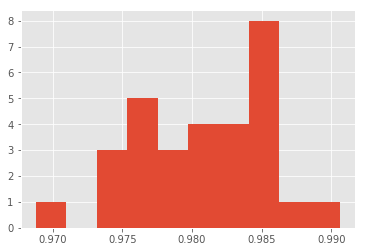

In [50]:
plt.hist(cross_val)
plt.show()

<Container object of 18 artists>

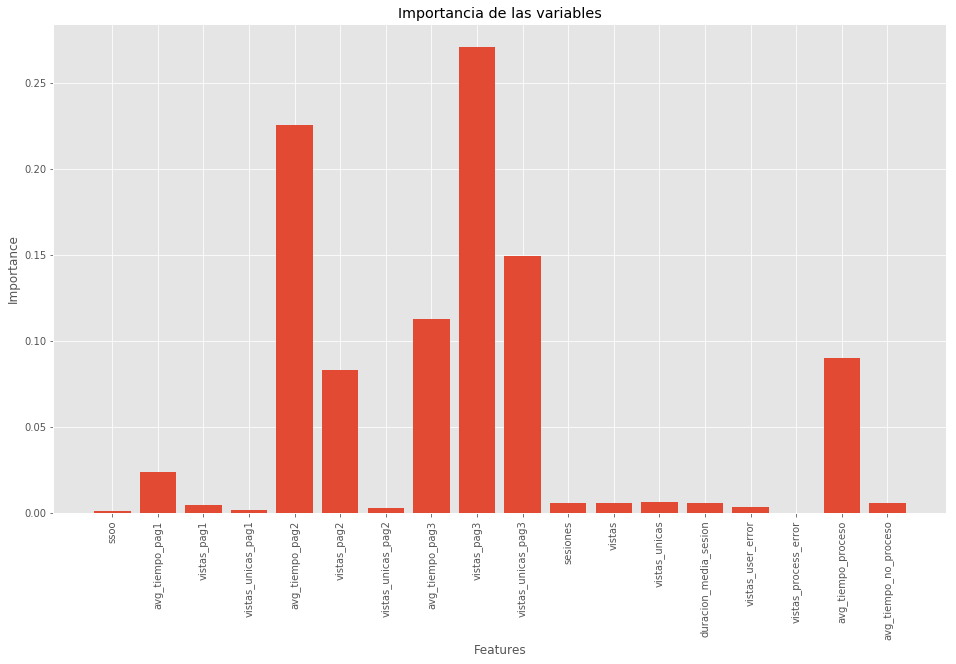

In [51]:
plt.figure(figsize=(16,9))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(range(18), df.columns[1:19], rotation='vertical')
plt.title('Importancia de las variables')
plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)

Como era de esperar, hay variables que tienen mucha importancia para el algoritmo y si nos fijamos son todas las que hacen referencia a las páginas 2 y 3 del proceso. Como hemos dicho esto se debe a las caracteristicas del proceso. Más adelante repetiremos el proceso eliminando estas variables.

Ya casi llegamos al final. Solo nos queda hacernos con la probabilidad que el algoritmo ha dado a nuestro usuario de haber comprado o no haber comprado. Este dato se consigue facilmente con el argumento **predict_proba**.

**predict_probaa** nos devuelve una lista de listas con dos valores para cada usuario, en la cual el primer valor es la probabilidad que el algoritmo le ha dado a ese usuario de que su etiquera hubiera sido 0 y el segundo valor sería lo contrario, la probabilidad que el algoritmo ha dado a ese usuario de que su etiqueta hubeira sido 1.

Ambas probabilidades suman 1 siempre.

In [52]:
prob = pd.DataFrame(clf.predict_proba(X_test).tolist())
predict = clf.predict(X_test).tolist()
prob['predict'] = predict
prob['Y'] = y_test
call = prob[(prob['Y']==0) & (prob[1]>0)] # Posibles usuarios susceptibles de remarketing
print "%i usuarios que no han contratado pero cuya probabilidad de compra es mayor que 0" %(len(call))
lista = call[1].values
data = [go.Histogram(x=lista)]

layout = go.Layout(
    title='Usuarios susceptibles de remarketing por probabilidad de compra',
    xaxis=dict(
        title='Probabilidad de compra'
    ),
    yaxis=dict(
        title='Número usuarios'
    ),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic histogram')

467 usuarios que no han contratado pero cuya probabilidad de compra es mayor que 0


Ya tenemos la forma de obtener las probabilidades. Ahora vamos a repetir el proceso de machine learning ya que para poder identificar a los usuarios necesitamos saber el identificador y al hacer el train_test_split la muestra se coge aleatoriamente por lo que no podemos identificarlos.

In [53]:
X_train , y_train  = df.iloc[:20000,:19] , df.iloc[:20000,19]
X_test  , y_test   = df.iloc[20001:,:19] , df.iloc[20001:,19]


clf = RandomForestClassifier(oob_score=True, random_state=42)
clf.fit(X_train[X_train.columns[1:]].values,y_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [54]:
accuracy_score(y_test.values, clf.predict(X_test[X_test.columns[1:]].values))

0.98166176137649985

In [55]:
# Las probabilidades pasadas a dataframe de dos columnas
prob = pd.DataFrame((clf.predict_proba(X_test[X_test.columns[1:]].values)).tolist())

# Añadimos otra columna con las predicciones
prob['Predict'] = clf.predict(X_test[X_test.columns[1:]].values).tolist()

# Otra columna que informe de si el cliente compró o no compró (nuestra Y)
prob['Y'] = y_test.tolist()

# Ahora añadimos el dataframe prob a nuestro x_test y ya tenemos el dataframe final.
X_test = X_test.reset_index(drop=True) # Reiniciamos el indice
df_final = pd.concat([X_test,prob], axis=1)

# Guardamos el df_final como archivo csv para tratarlo desde Data Studio y desde Tableau
! rm ./probabilidades_por_usuario.csv
df_final.to_csv('probabilidades_por_usuario.csv')


#### Una cosa más...

Ya tenemos el resultado que queriamos, pero el hecho de que tengamos variables que influyen muchísimo más que otras debido a este proceso en concreto, hace que el algoritmo tenga muy claro que determinados usuarios no van a comprar proque no han pasado de la primera página.

Considero que vale la pensa investigar cual sería el resultado si obviaramos las variables de la página 2 y 3 del proceso.

In [58]:
# Eliminamos las variables
(df.drop(['avg_tiempo_pag2','vistas_pag2','avg_tiempo_pag3',
               'vistas_pag3', 'vistas_unicas_pag3', 'vistas_unicas_pag2'],1, inplace=True))

In [64]:
# Machine learning sin variables de pagina 2 y 3
X = df[df.columns[1:13]].values
y = df['Y']


clf = RandomForestClassifier(oob_score=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,y)

clf.fit(X_train,y_train)
accuracy_score(y_test,clf.predict(X_test))

0.90692190317658483

In [65]:
cross_val = cross_val_score(clf,X,y,cv=30)

print cross_val
print 'Precisión media: {0:.1f}%'.format(cross_val.mean()*100)
print 'Desviación estandar: {0:.2f}'.format(cross_val.std())

[ 0.90540541  0.92307692  0.91683992  0.91268191  0.91164241  0.9043659
  0.9043659   0.9012474   0.91580042  0.9043659   0.92099792  0.90738814
  0.91155047  0.9094693   0.92091571  0.90842872  0.91050989  0.9094693
  0.90010406  0.90842872  0.91155047  0.8855359   0.89594173  0.90842872
  0.91354167  0.903125    0.90729167  0.91041667  0.91666667  0.90625   ]
Precisión media: 90.9%
Desviación estandar: 0.01


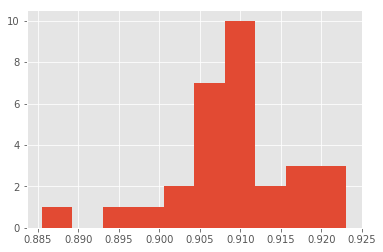

In [66]:
plt.hist(cross_val)
plt.show()

<Container object of 12 artists>

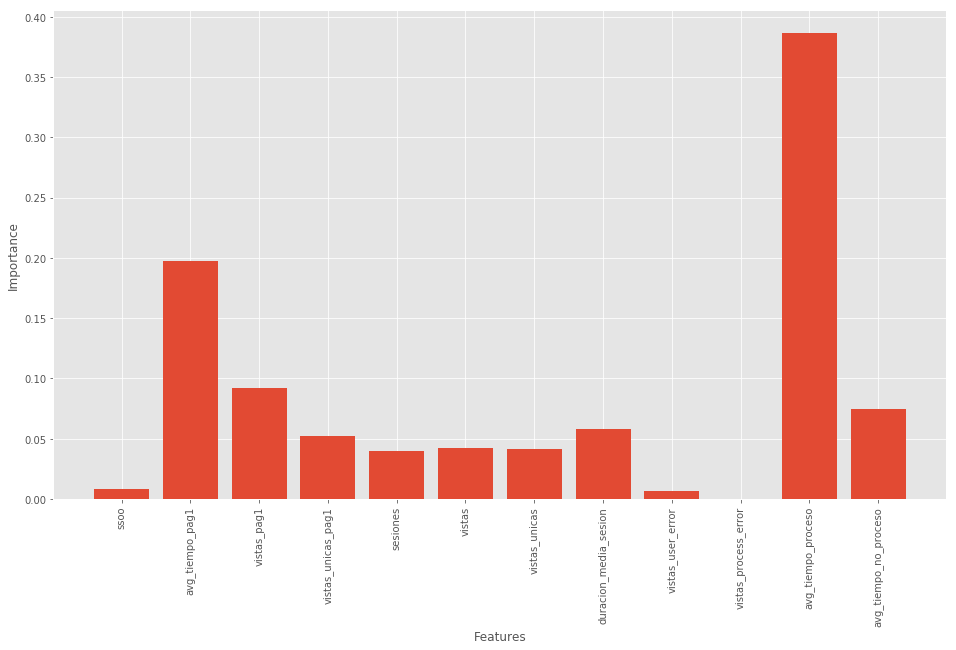

In [69]:
plt.figure(figsize=(16,9))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(range(14), df.columns[1:14], rotation='vertical')
plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)

In [70]:
prob = pd.DataFrame(clf.predict_proba(X_test).tolist())
predict = clf.predict(X_test).tolist()
prob['predict'] = predict
prob['Y'] = y_test
call = prob[(prob['Y']==0) & (prob[1]>0)] # Posibles usuarios susceptibles de remarketing
print "%i usuarios que no han contratado pero cuya probabilidad de compra es mayor que 0" %(len(call))
lista = call[1].values
data = [go.Histogram(x=lista)]

layout = go.Layout(
    title='Usuarios susceptibles de remarketing por probabilidad de compra',
    xaxis=dict(
        title='Probabilidad de compra'
    ),
    yaxis=dict(
        title='Número usuarios'
    ),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic histogram')

660 usuarios que no han contratado pero cuya probabilidad de compra es mayor que 0


## Conclusión

El final de este proyecto podría resumirse con depende... ¿Usamos las variables de las páginas 2 y 3 o no las usamos?

Bajo mi punto de vista, depende de lo que se quiera hacer con esta información. Si lo que buscamos es, por ejemplo, hacer una campaña de remarketing mediante un contact center, habría que preguntarse si lo que buscamos captar al máximo número de clientes posibles o ser lo más eficientes que podamos. Dependiendo de cada situación, la elección será una u otra.